In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from math import floor
from pandas.tseries.offsets import MonthEnd
import plotting 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
import matplotlib.patches as mpatches
from matplotlib import colors
from os import path
import geopandas as gpd
import json
import re

In [45]:
_HOME_ = path.expanduser("~") + "/PHD"
import modify_dataset

In [46]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]
transects_info = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [47]:
from_region_to_abreviation = {
    "Friuli-Venezia-Giulia" : "FVG",
    "Veneto" : "VEN", 
    "Emilia-Romagna" : "EMR",
    "Marche" : "MAR",
    "Abruzzo" : "ABR",
    "Molise" : "MOL",
    "Puglia" : "PUG",
    "Basilicata" : "BAS",
    "Calabria" : "CAL",
    "Campania" : "CAM", 
    "Lazio" : "LAZ",
    "Toscana" : "TOS",
    "Liguria" : "LIG",
     "Sicilia" : "SIC",
    "Sardegna" : "SAR"
}

In [48]:
phyto_abund_simplified["Region"] = phyto_abund_simplified["Region"].map(from_region_to_abreviation)

In [49]:
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = list(from_region_to_abreviation.values()), ordered = True)

In [50]:
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == 'Pseudo-nitzschia spp. del nitzschia delicatissima complex', "Taxon"] = 'Nitzschia delicatissima complex'
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == 'Pseudo-nitzschia spp. del nitzschia seriata complex', "Taxon"] = 'Nitzschia seriata complex'

In [51]:
stations_basins = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Stations_Basins.csv")

In [52]:
phyto_abund_simplified = phyto_abund_simplified.merge(stations_basins, how = "left", on = "id")

In [ ]:
dat = phyto_abund_simplified.pivot_table(
    index = ["Region", "Date", "id"],
    columns = ["Det_level", "Taxon"], 
    values = "Num_cell_l",
    fill_value = 0
)

In [105]:
dat.to_csv(_HOME_ + "/ISPRA_20152017_Analysis/site_taxa_matrix_w_det_level.csv")

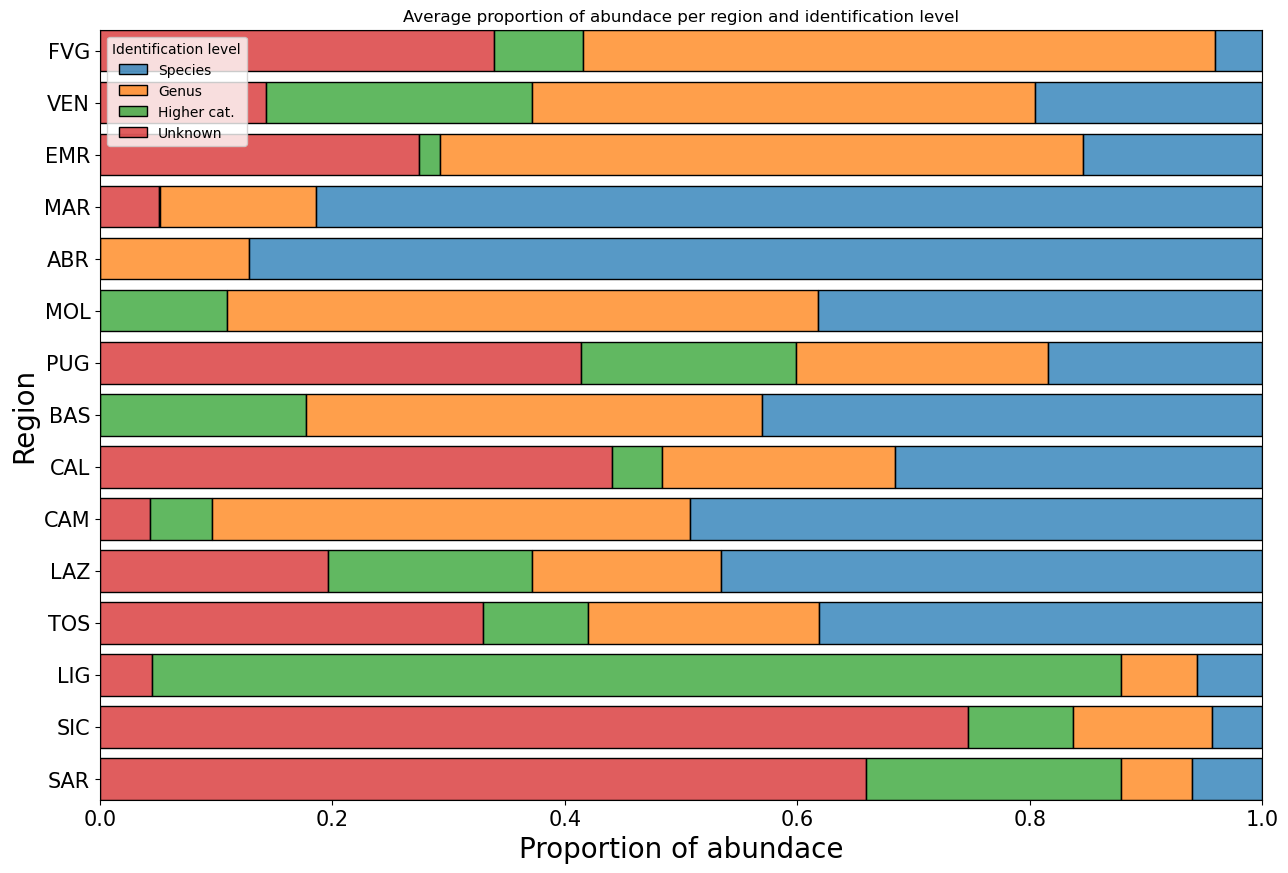

In [131]:
fig, ax = plt.subplots(figsize=(15, 10))
data = phyto_abund_simplified.groupby(["Date", "id", "Det_level"]).agg(
        {
            "Num_cell_l" : "sum", 
            "Region" : "first"
        }).reset_index().groupby(["Region", "Det_level"], observed = True).mean(numeric_only=True).reset_index().rename(columns={"Det_level" : "Identification level"})
data["Identification level"] = pd.Categorical(data["Identification level"], categories = ["Unknown", "Higher cat.", "Genus", "Species"][::-1], ordered = True)
sns.histplot(
        data=data.sort_values(by="Identification level"),
        y="Region", hue="Identification level", weights="Num_cell_l",
        multiple="fill", stat="proportion",
        discrete=True, shrink=.8, legend=True,
        ax = ax
    )
ax.set_xlabel("Proportion of abundace", size = 20)
ax.set_ylabel("Region", size = 20)
ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 15)
ax.set_yticks(ticks=ax.get_yticks(), labels = ax.get_yticklabels(), size = 15)
ax.set_title("Average proportion of abundace per region and identification level")
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/average_proportion_cells_per_region_and_identification_level.png", bbox_inches="tight")

In [76]:
phyto_classes = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/phyto_classes.csv")

In [77]:
top_taxa = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_freq_95.csv")
top_species = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_top.csv")
top_genera = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Genera_freq_top.csv")
top_classes = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Classes_freq_top.csv").dropna()

In [78]:
rich_classes = phyto_abund_simplified.query("Taxon != 'Other phytoplankton' and Det_level == 'Species'")[["Class", "Taxon"]].groupby("Class").nunique().sort_values("Taxon", ascending = False).reset_index()
rich_genera = phyto_abund_simplified.query("Taxon != 'Other phytoplankton' and Det_level == 'Species'")[["Genus", "Taxon"]].groupby("Genus").nunique().sort_values("Taxon", ascending = False).reset_index()

In [122]:
np.round(data.iloc[:n_otu,1].to_numpy() / n_samples, 2)

array([0.62, 0.58, 0.54, 0.53, 0.5 , 0.47, 0.46, 0.45, 0.44, 0.42])

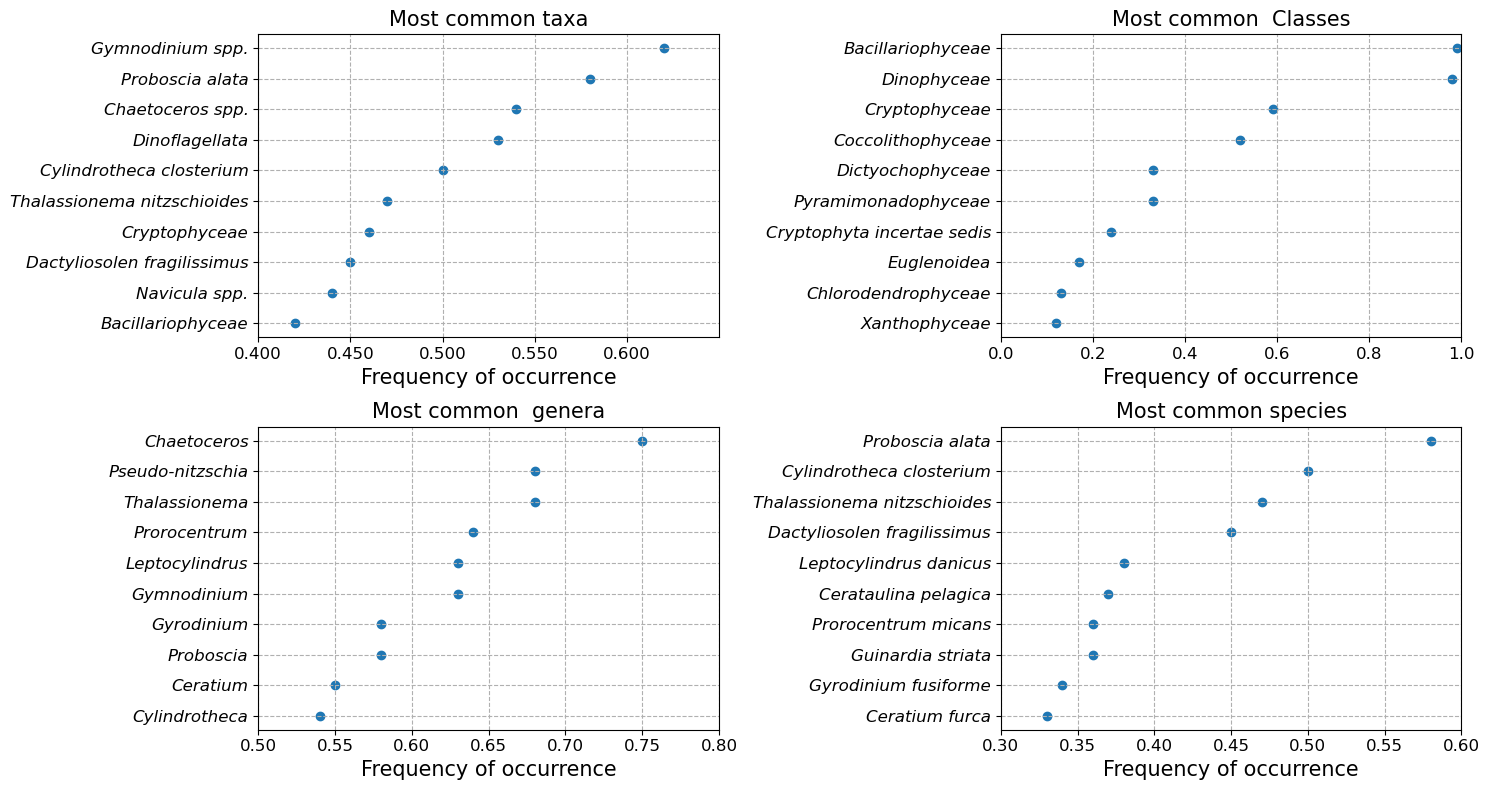

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flatten()

n_otu = 10
n_samples = 2220
for ax, data, title in zip(axs, 
                           [top_taxa, top_classes, top_genera, top_species], 
                           ["Most common taxa", "Most common  Classes", "Most common  genera", "Most common species"]
                           ):
    ith_otu = np.arange(len(data))[:n_otu][::-1]
    ax.scatter(np.round(data.iloc[:n_otu,1].to_numpy() / n_samples, 2), ith_otu)
    ax.set_title(title, size = 15)
    ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 12)
    ax.set_yticks(
        ith_otu, 
        labels = data.iloc[:n_otu,0].to_numpy(), 
        style = "italic", 
        size = 12
    )
    ax.grid(True, which='major', axis="both", linestyle='--')
    ax.set_xlabel("Frequency of occurrence", size = 15)
    
axs[0].set_xticks(ticks=axs[0].get_xticks()[:-1:2], labels = axs[0].get_xticklabels()[:-1:2], size = 12)
axs[1].set_xlim(0,1)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/most_common_taxa_classes_genera_species.png", bbox_inches="tight")

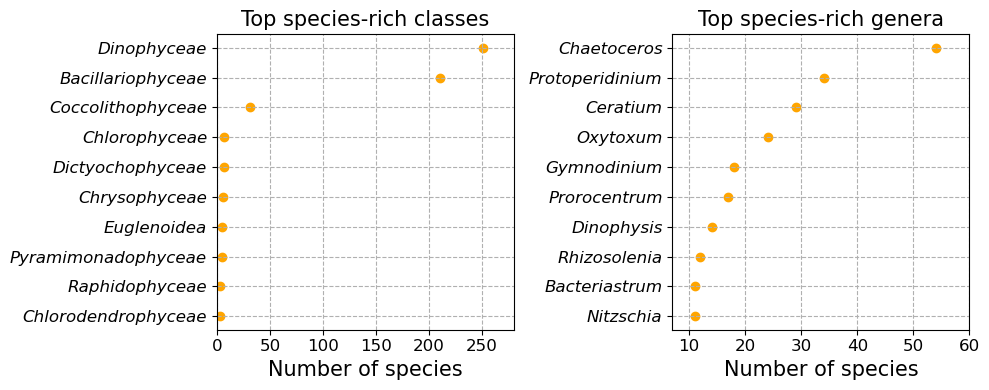

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

for ax, data, title in zip(axs, [rich_classes, rich_genera], ["Top species-rich classes", "Top species-rich genera"]):
    ith_otu = np.arange(len(data))[:n_otu][::-1]
    ax.scatter(data.iloc[:n_otu,1].to_numpy(), ith_otu, color = "orange")
    ax.set_yticks(
        ith_otu, 
        labels = data.iloc[:n_otu,0].to_numpy(), 
        style = "italic", 
        size = 12
    )
    ax.set_title(title, size = 15)
    ax.set_xlabel("Number of species", size = 15)
    ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 12)
    ax.grid(True, which='major', axis="both", linestyle='--')
axs[0].set_xlim(0,280)
axs[1].set_xlim(7,60)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/top_species_rich_classes_genera.png", bbox_inches="tight")

In [89]:
taxa_frequnecy = phyto_abund_simplified.groupby("Taxon").count()[["Num_cell_l"]].sort_values("Num_cell_l", ascending = False) / 2220

In [92]:
print(f"Number of rare taxa: {len(taxa_frequnecy.query("Num_cell_l < 0.01"))}")
print(f"Number of intermediate taxa: {len(taxa_frequnecy.query("Num_cell_l >= 0.01 and Num_cell_l < 0.1"))}")
print(f"Number of common taxa: {len(taxa_frequnecy.query("Num_cell_l >= 0.1"))}")

Number of rare taxa: 462
Number of intermediate taxa: 228
Number of common taxa: 77


In [148]:
det_level = "Genus"
df = phyto_abund_simplified.loc[:, ["Taxon", det_level, "Class", "Num_cell_l", "Basin", "Season"]]
df.loc[df["Genus"].isna(), "Genus"] = df.loc[df[det_level].isna(), "Taxon"]
df.loc[df["Genus"] == "Other phytoplankton", "Genus"] = "Unknown"
taxa_abund_season_basin = df.groupby(["Basin", "Season", det_level], observed=True).sum(numeric_only=True)[["Num_cell_l"]]

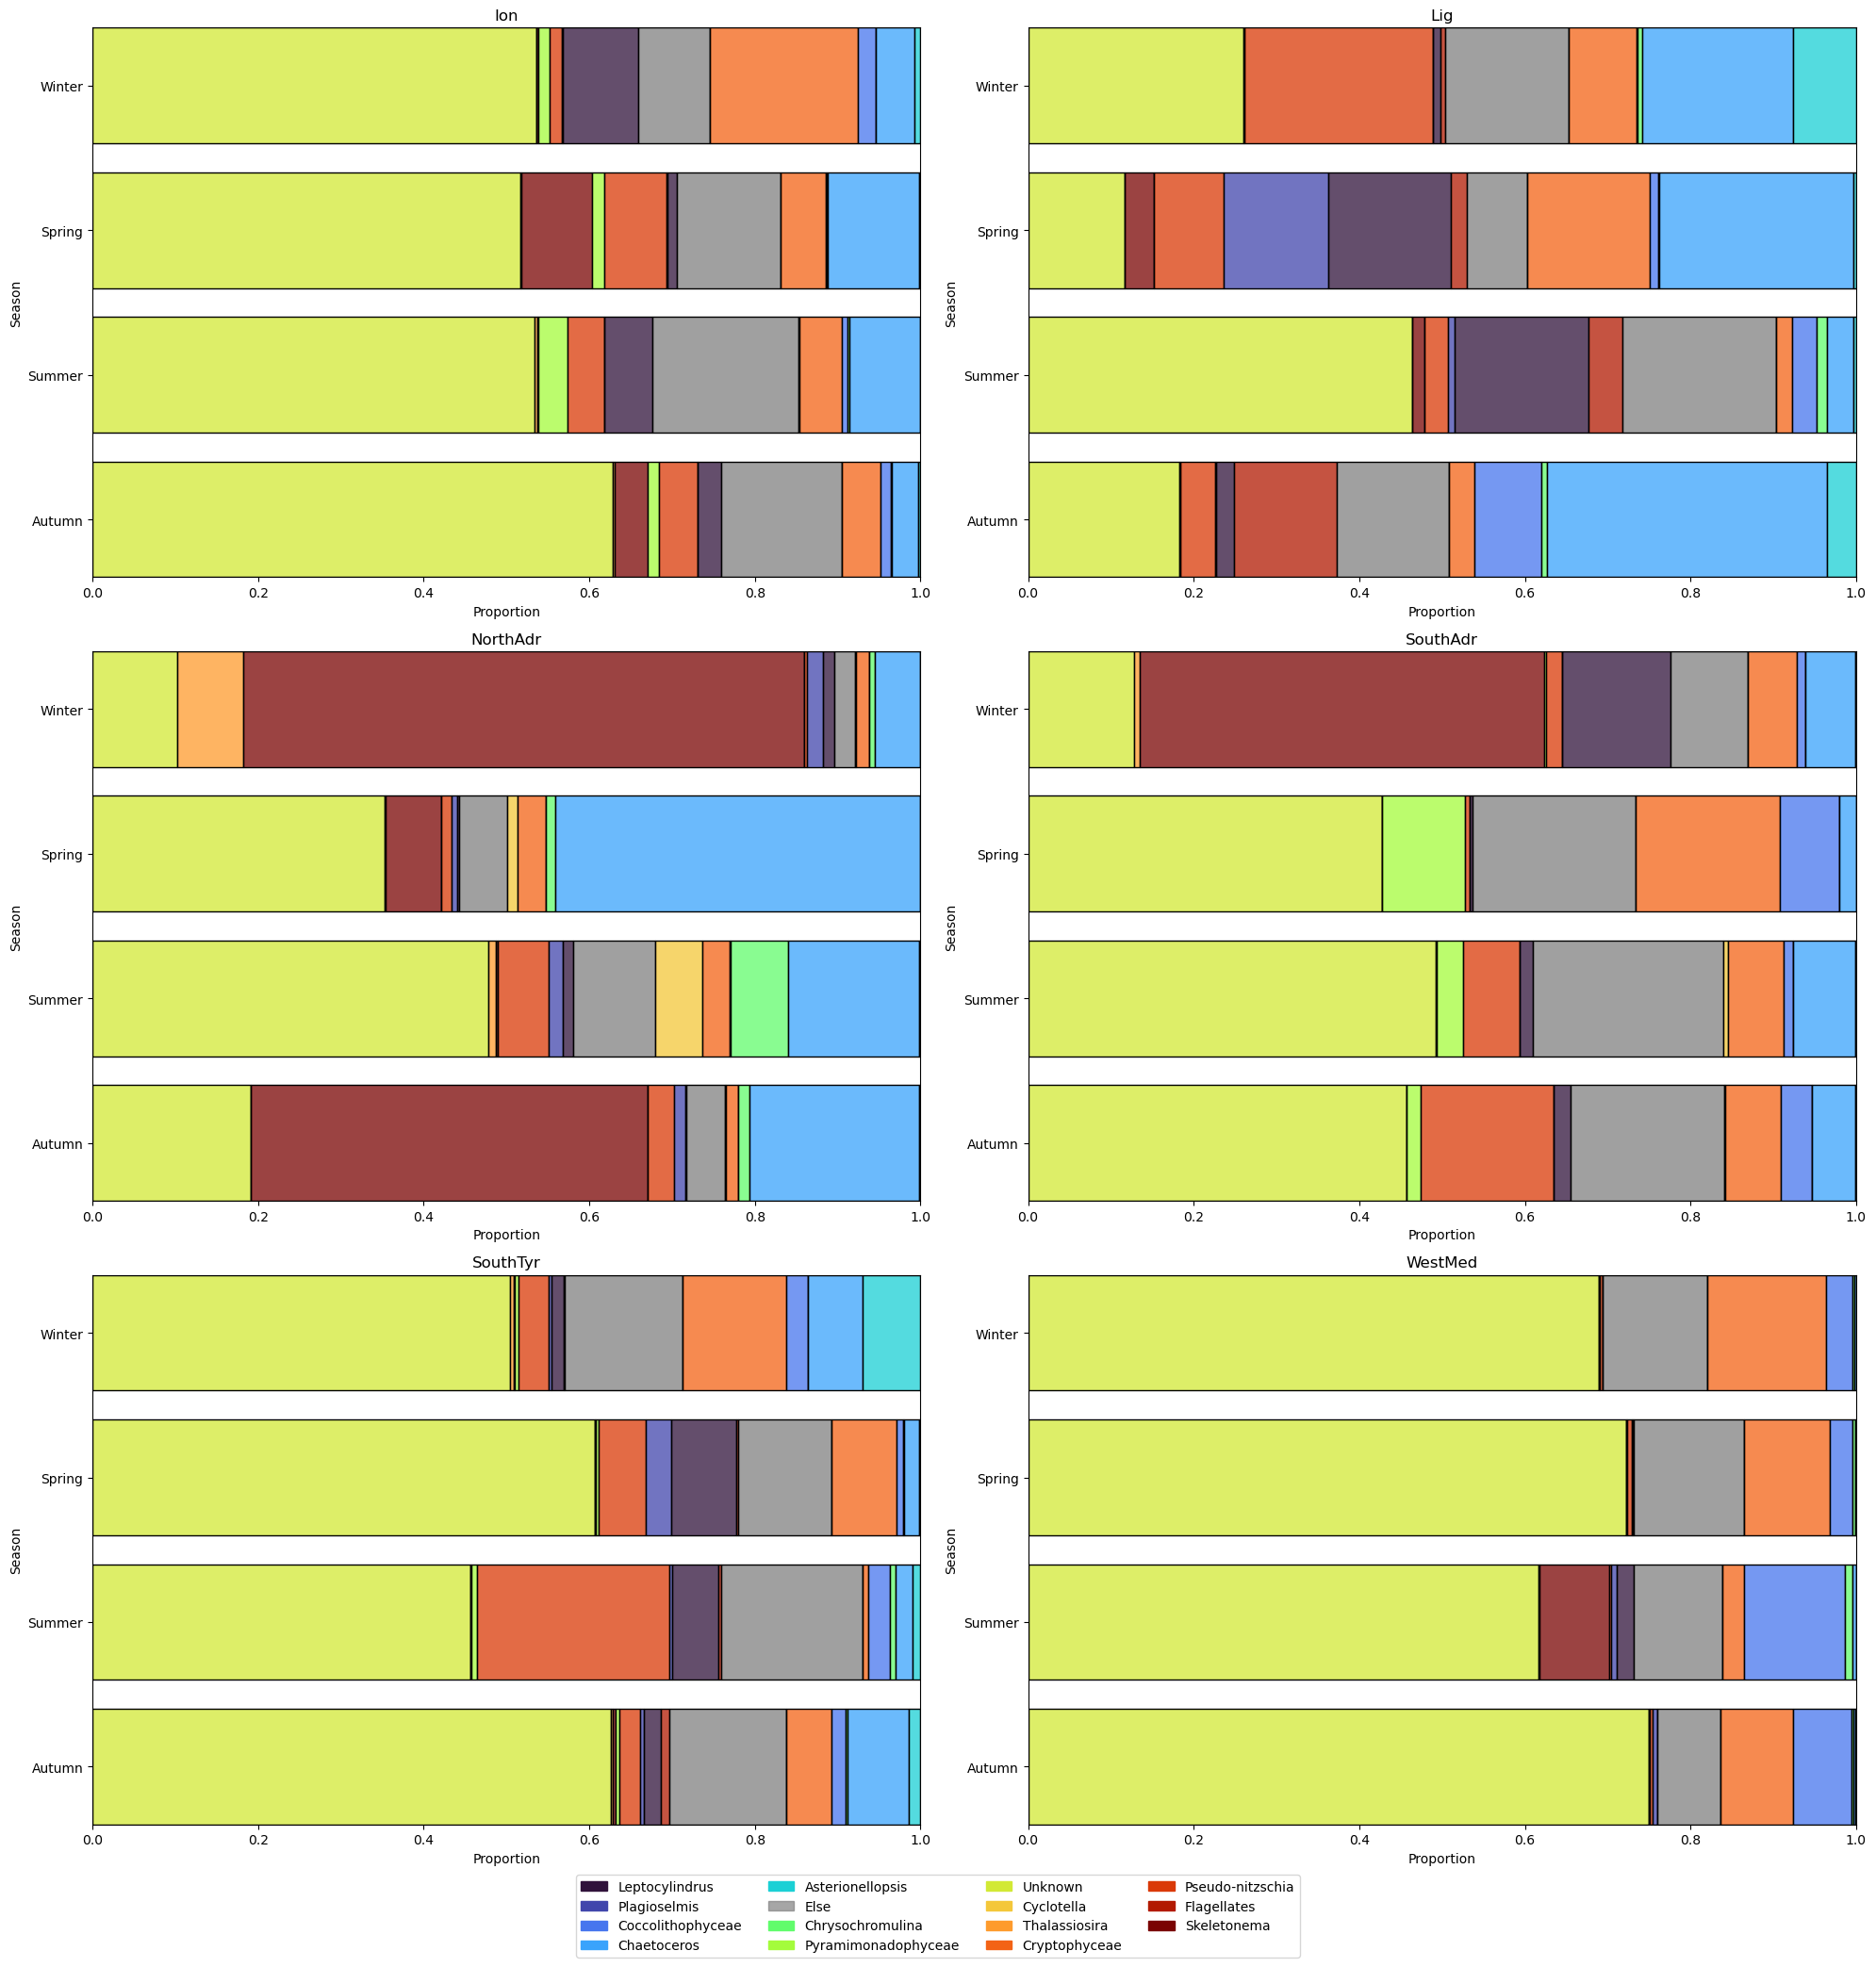

In [149]:

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.ravel()
taxa_above_threshold = set()
for basin_name, df_basin in taxa_abund_season_basin.groupby("Basin", observed=True): 
    taxa_above_threshold = taxa_above_threshold.union(
    df_basin.div(df_basin.groupby(level = "Season", observed = True).sum(numeric_only=True)).query("Num_cell_l > 0.05").index.get_level_values(det_level).unique()
    )

taxa_above_threshold = taxa_above_threshold.union(["Else"])
num_colors = len(taxa_above_threshold)
colors = plt.get_cmap("turbo")(np.linspace(0, 1, num_colors))
color_dict = {name: color for name, color in zip(taxa_above_threshold, colors)}
color_dict["Bacillariophyceae"] = [123 / 255, 62 / 255, 228 / 255, 0.7]
color_dict["Else"] = [0.5, 0.5, 0.5, 0.7]

for ax, (basin_name, df_basin) in zip(axs, taxa_abund_season_basin.groupby("Basin", observed=True)): 
    df = df_basin.reset_index()
    df.loc[~df[det_level].isin(taxa_above_threshold), det_level] = "Else"

    sns.histplot(
        data=df.groupby(["Season", det_level], observed=True).sum(numeric_only=True).sort_values(by = det_level),
        y="Season", hue=det_level, weights="Num_cell_l",
        multiple="fill", stat="proportion",
        palette = color_dict,
        discrete=True, shrink=.8, legend=False,
        ax = ax
    )
    ax.set_title(basin_name)

handles = [mpatches.Patch(color=color_dict[name], label=name) for name in taxa_above_threshold]
fig.legend(handles=handles, bbox_to_anchor=(0, -.07, 1, 0.101), loc='center', ncol=4)
plt.tight_layout()

# SAR analysis

In [31]:
phyto_abund_simplified.query("Region == 'SAR' and Basin == 'WestMed'").drop_duplicates(["Date", "id"])

,Region,id,Longitude,Latitude,Closest_coast,Coast_dist,Date,Season_year,Season,Sample_depth,Class,Genus,Det_level,Taxon,Num_cell_l,file_name,Transect,SeaDepth,Basin
44651,SAR,0182-MS01070_TR03,8.39275,40.8882,5.556,near,2015-07-31,Summer-2015,Summer,0.5,Dinophyceae,Akashiwo,Species,Akashiwo sanguinea,30.000,Modulo_1_20161013140750_ARPA_Liguria_Sardegna.xls,PORTO_TORRES,33.0,WestMed
44693,SAR,0182-MS01070_TR03,8.39275,40.8882,5.556,near,2015-09-30,Summer-2015,Summer,0.5,Dinophyceae,Akashiwo,Species,Akashiwo sanguinea,160.000,Modulo_1_20161013141824_ARPA_Liguria_Sardegna.xls,PORTO_TORRES,33.0,WestMed
44744,SAR,0182-MS01070_TR03,8.39275,40.8882,5.556,near,2015-11-30,Autumn-2015,Autumn,0.5,Dinophyceae,Amphidinium,Genus,Amphidinium spp.,440.000,Modulo_1_20161013143739_ARPA_Liguria_Sardegna.xls,PORTO_TORRES,33.0,WestMed
44787,SAR,0182-MS01070_TR03,8.39275,40.8882,5.556,near,2016-01-31,Winter-2016,Winter,0.5,Dinophyceae,Amphidinium,Genus,Amphidinium spp.,617.000,Modulo_1_20161013144130_ARPA_Liguria_Sardegna.xls,PORTO_TORRES,33.0,WestMed
44830,SAR,0182-MS01070_TR03,8.39275,40.8882,5.556,near,2016-06-30,Spring-2016,Spring,0.5,Dinophyceae,Alexandrium,Genus,Alexandrium spp.,40.000,Modulo_1_20170217102503_ARPA_Liguria_Sardegna.xls,PORTO_TORRES,33.0,WestMed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49423,SAR,0222-MS01380_TR12,8.34535,39.7523,22.224,far,2017-03-31,Winter-2017,Winter,0.5,Dinophyceae,Alexandrium,Genus,Alexandrium spp.,70.000,Modulo_1_20170718072803_ARPA_Liguria_Sardegna.xls,ORISTANO,49.0,WestMed
49455,SAR,0222-MS01380_TR12,8.34535,39.7523,22.224,far,2017-05-31,Spring-2017,Spring,0.5,Dinophyceae,Ceratium,Species,Ceratium furca,110.000,Modulo_1_20170809081330_ARPA_Liguria_Sardegna.xls,ORISTANO,49.0,WestMed
49476,SAR,0222-MS01380_TR12,8.34535,39.7523,22.224,far,2017-07-31,Summer-2017,Summer,0.5,Bacillariophyceae,NaN,Higher cat.,Bacillariophyceae,705.545,Modulo_1_20171116104129_ARPA_Liguria_Sardegna.xls,ORISTANO,49.0,WestMed
49523,SAR,0222-MS01380_TR12,8.34535,39.7523,22.224,far,2017-09-30,Summer-2017,Summer,0.5,Dinophyceae,Amphidinium,Species,Amphidinium extensum,20.000,Modulo_1_20180111145944_ARPA_Liguria_Sardegna.xls,ORISTANO,49.0,WestMed


In [32]:
phyto_abund_simplified.query("Basin == 'SouthTyr'").drop_duplicates(["Date", "id"])

,Region,id,Longitude,Latitude,Closest_coast,Coast_dist,Date,Season_year,Season,Sample_depth,Class,Genus,Det_level,Taxon,Num_cell_l,file_name,Transect,SeaDepth,Basin
3249,CAL,M1T5A,16.0715,38.7552,5.556,near,2017-02-28,Winter-2017,Winter,0.5,nan,NaN,Higher cat.,Dinoflagellata,360.0,Modulo_1_20170807131212_ARPA_Calabria_Calabria...,VIBO_MARINA,140.0,SouthTyr
3258,CAL,M1T5A,16.0715,38.7552,5.556,near,2017-07-31,Summer-2017,Summer,0.5,Dinophyceae,Ceratium,Species,Ceratium furca,140.0,Modulo_1_20171004104240_ARPA_Calabria_Calabria...,VIBO_MARINA,140.0,SouthTyr
3271,CAL,M1T5A,16.0715,38.7552,5.556,near,2017-09-30,Summer-2017,Summer,0.5,Coccolithophyceae,Calyptrosphaera,Genus,Calyptrosphaera spp.,3028.0,Modulo_1_20171123110354_ARPA_Calabria_Calabria...,VIBO_MARINA,140.0,SouthTyr
3293,CAL,M1T5B,16.0390,38.7975,11.112,mid,2015-09-30,Summer-2015,Summer,0.5,Bacillariophyceae,Asteromphalus,Species,Asteromphalus flabellatus,120.0,Modulo_1_20170807121621_ARPA_Calabria_Calabria...,VIBO_MARINA,400.0,SouthTyr
3318,CAL,M1T5B,16.0390,38.7975,11.112,mid,2016-02-29,Winter-2016,Winter,0.5,Dinophyceae,Alexandrium,Species,Alexandrium minutum,40.0,Modulo_1_20170807130635_ARPA_Calabria_Calabria...,VIBO_MARINA,400.0,SouthTyr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55541,SIC,SMM1C,12.7712,37.4586,22.224,far,2017-04-30,Spring-2017,Spring,0.5,Bacillariophyceae,NaN,Higher cat.,Bacillariophyceae,1120.0,Modulo_1_20170531170902_ARPA_Calabria_Sicilia.xls,SAN_MARCO,94.5,SouthTyr
55565,SIC,SMM1C,12.7712,37.4586,22.224,far,2017-05-31,Spring-2017,Spring,0.5,Bacillariophyceae,Cerataulina,Species,Cerataulina pelagica,40.0,Modulo_1_20170731122637_ARPA_Calabria_Sicilia.xls,SAN_MARCO,94.5,SouthTyr
55591,SIC,SMM1C,12.7712,37.4586,22.224,far,2017-07-31,Summer-2017,Summer,0.5,Bacillariophyceae,NaN,Higher cat.,Bacillariophyceae,120.0,Modulo_1_20171003105515_ARPA_Calabria_Sicilia....,SAN_MARCO,94.5,SouthTyr
55612,SIC,SMM1C,12.7712,37.4586,22.224,far,2017-10-31,Autumn-2017,Autumn,0.5,Bacillariophyceae,NaN,Higher cat.,Bacillariophyceae,80.0,Modulo_1_20171130163316_ARPA_Calabria_Sicilia.xls,SAN_MARCO,94.5,SouthTyr


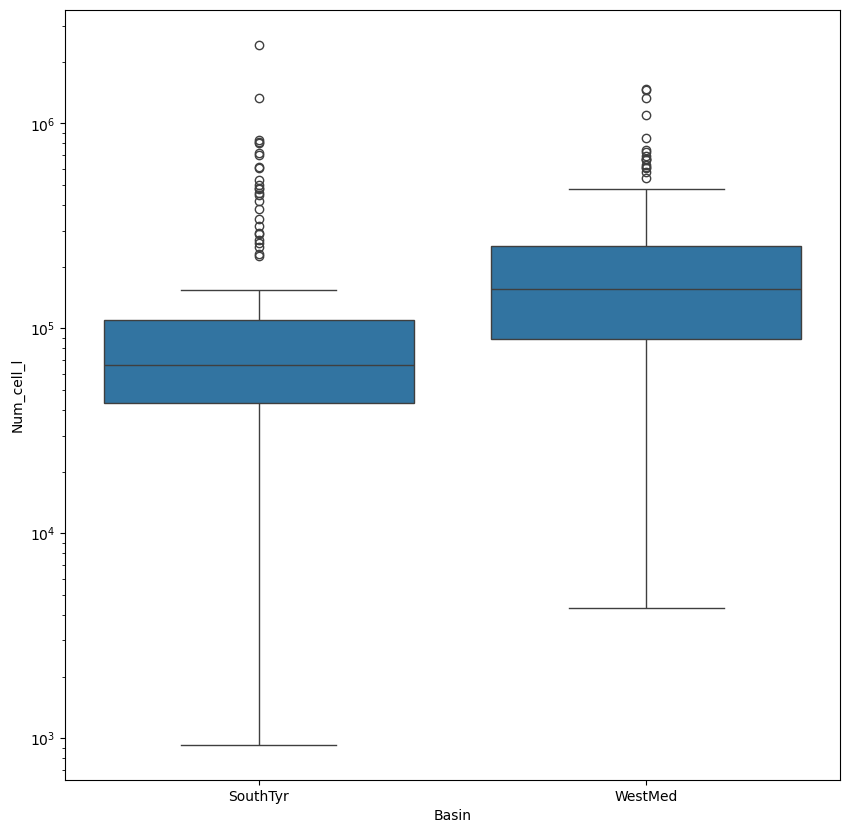

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(
phyto_abund_simplified.query("Region == 'SAR'").groupby(["Date", "id"]).agg(
    {
        "Num_cell_l" : "sum", 
        "Basin" : "first"
    }),
    x = "Basin", 
    y = "Num_cell_l", 
    ax = ax
)
ax.set_yscale("log")

<Axes: xlabel='Basin', ylabel='Taxon'>

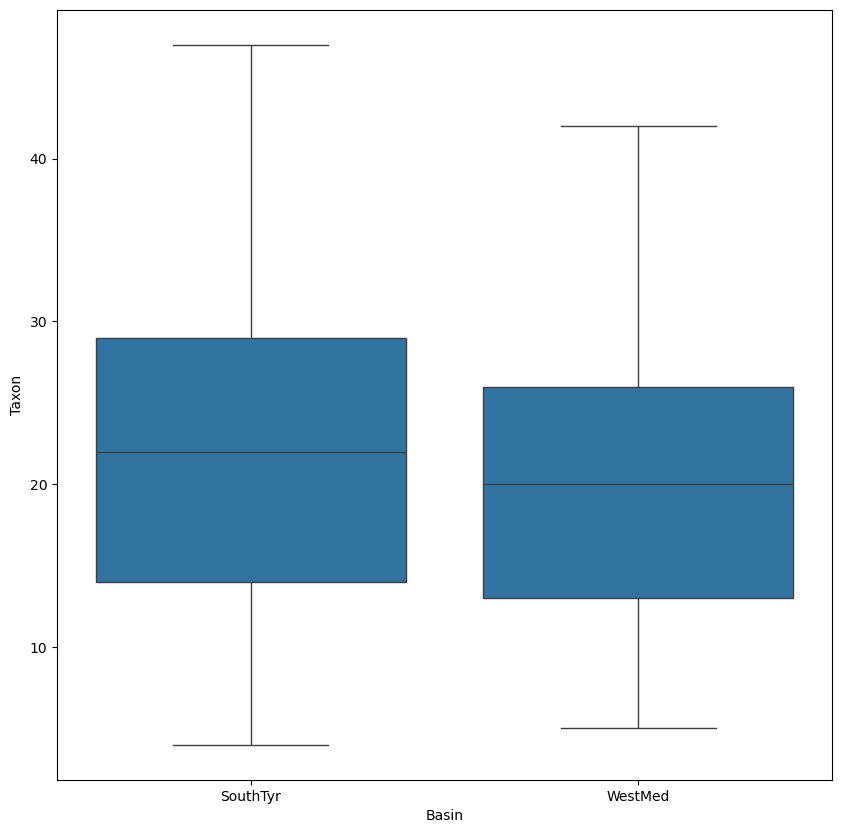

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(
phyto_abund_simplified.query("Region == 'SAR' and Det_level == 'Species'").groupby(["Date", "id"]).agg(
    {
        "Taxon" : "count", 
        "Basin" : "first"
    }),
    x = "Basin", 
    y = "Taxon", 
    ax = ax
)
#ax.set_yscale("log")

/home/alberto/miniconda3/envs/BDV/lib/python3.12/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


<Axes: >

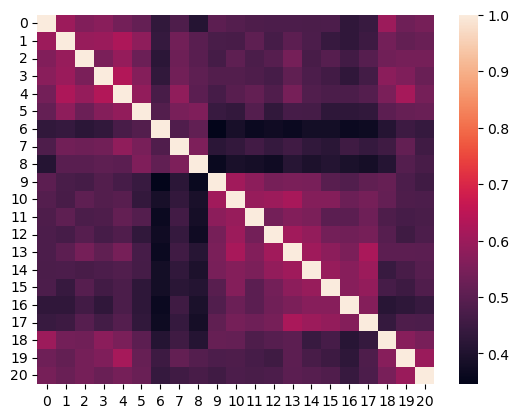

In [28]:
from sklearn.metrics.pairwise import pairwise_distances
sns.heatmap(1 - pairwise_distances(phyto_abund_simplified.query("Region == 'SAR'").pivot_table(index = ["Basin", "id"], columns="Taxon", aggfunc="count", values="Num_cell_l", fill_value=0).to_numpy(), metric = "jaccard"))

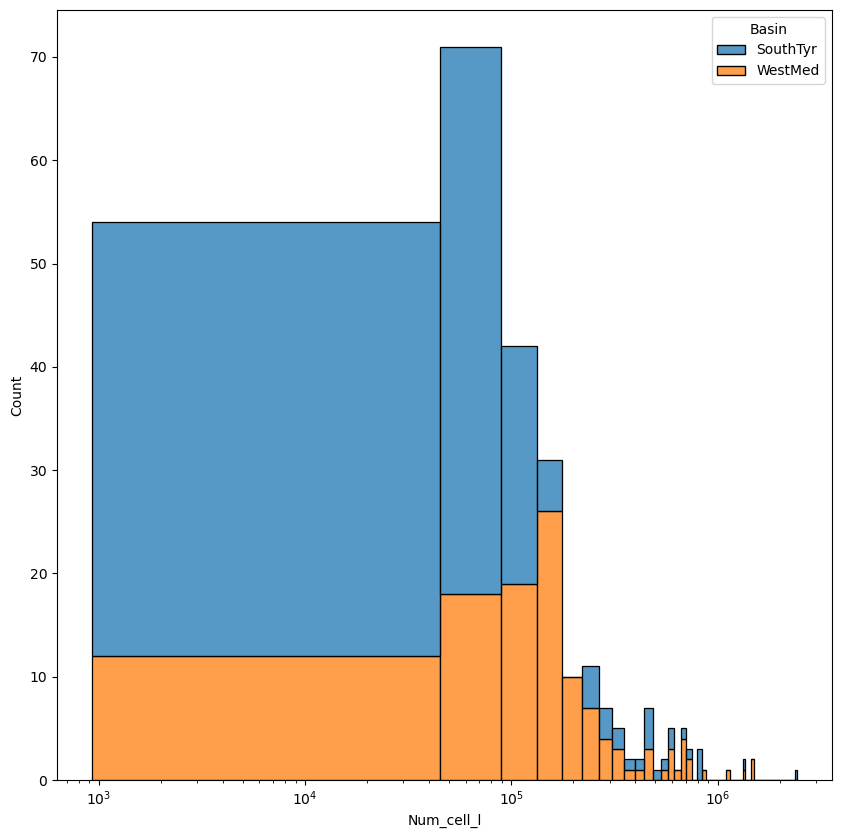

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(
phyto_abund_simplified.query("Region == 'SAR'").groupby(["Date", "id"]).agg(
    {
        "Num_cell_l" : "sum", 
        "Basin" : "first"
    }), 
    x = "Num_cell_l", 
    hue = "Basin",
    multiple= "stack",
    ax = ax
)
ax.set_xscale("log")

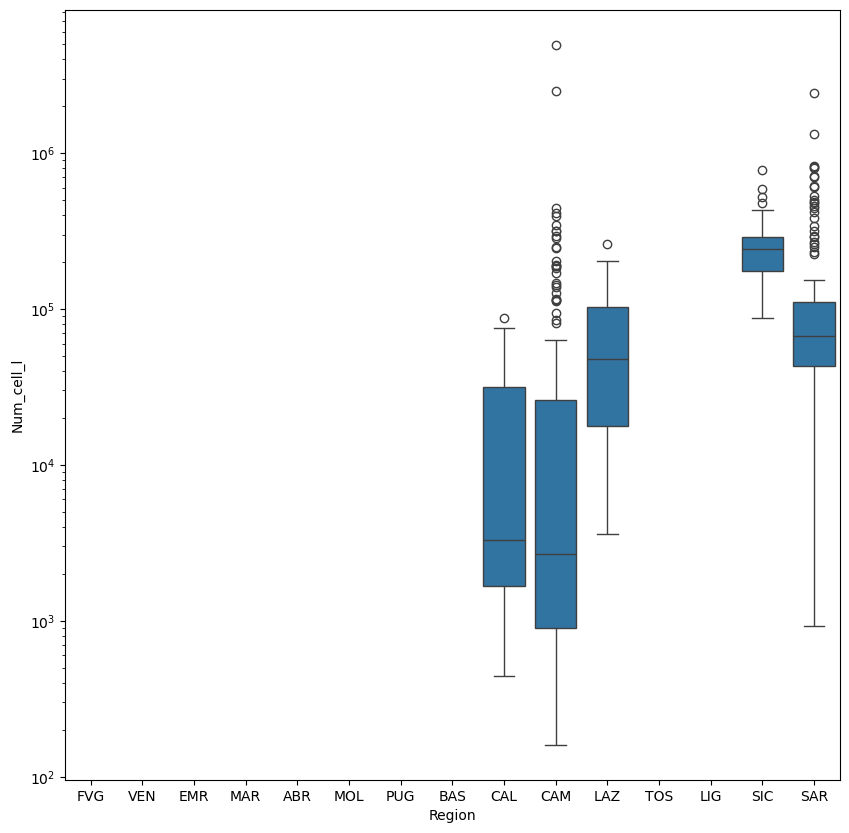

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(
phyto_abund_simplified.query("Basin == 'SouthTyr'").groupby(["Date", "id"]).agg(
    {
        "Num_cell_l" : "sum", 
        "Region" : "first"
    }),
    x = "Region", 
    y = "Num_cell_l", 
    ax = ax
)
ax.set_yscale("log")

In [38]:
phyto_abund_simplified.query("Basin == 'SouthTyr'").pivot_table(index = ["Region", "id"], columns="Taxon", aggfunc="count", values="Num_cell_l", fill_value=0, observed=True)

Taxon                     Acanthoica aculeata  Achradina pulchra  \
Region id                                                          
CAL    M1T5A                                0                  0   
       M1T5B                                0                  0   
       M1T5C                                0                  0   
       M1T6A                                0                  0   
       M1T6B                                0                  0   
       M1T6C                                0                  0   
CAM    M1CL12                               0                  0   
       M1CL3                                0                  0   
       M1CL6                                0                  0   
       M1FV12                               0                  0   
       M1FV3                                0                  0   
       M1FV6                                0                  0   
       M1GN12                               0                  0   
       M1GN3                                0                  0   
       M1GN6                                0                  0   
       M1GS12                               0                  0   
       M1GS3                                0                  0   
       M1GS6                                0                  0   
LAZ    IT_m1lt01_12                         0                  0   
       IT_m1lt01_3                          0                  0   
       IT_m1lt01_6                          1                  0   
       IT_m1lt02_12                         0                  0   
       IT_m1lt02_3                          0                  0   
       IT_m1lt02_6                          0                  0   
SIC    CGM1A                                0                  0   
       CGM1B                                0                  0   
       CGM1C                                0                  0   
       IEM1A                                0                  0   
       IEM1B                                0                  0   
       IEM1C                                0                  0   
       SMM1A                                0                  0   
       SMM1B                                0                  2   
       SMM1C                                0                  0   
SAR    0004-MS00200_TR03                    0                  0   
       0004-MS00200_TR06                    0                  0   
       0004-MS00200_TR12                    0                  0   
       0018-MS00110_TR03                    0                  0   
       0018-MS00110_TR06                    0                  0   
       0018-MS00110_TR12                    0                  0   
       0073-MS00370_TR03                    0                  0   
       0073-MS00370_TR06                    0                  0   
       0073-MS00370_TR12                    0                  0   
       0129-MS00730_TR03                    0                  0   
       0129-MS00730_TR06                    0                  0   
       0129-MS00730_TR12                    0                  0   

Taxon                     Akashiwo sanguinea  Alexandrium minutum  \
Region id                                                           
CAL    M1T5A                               0                    0   
       M1T5B                               0                    1   
       M1T5C                               0                    0   
       M1T6A                               0                    0   
       M1T6B                               0                    0   
       M1T6C                               0                    0   
CAM    M1CL12                              0                    0   
       M1CL3                               0                    0   
       M1CL6                               0                    0   
       M1FV12                              0

/home/alberto/miniconda3/envs/BDV/lib/python3.12/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


<Axes: >

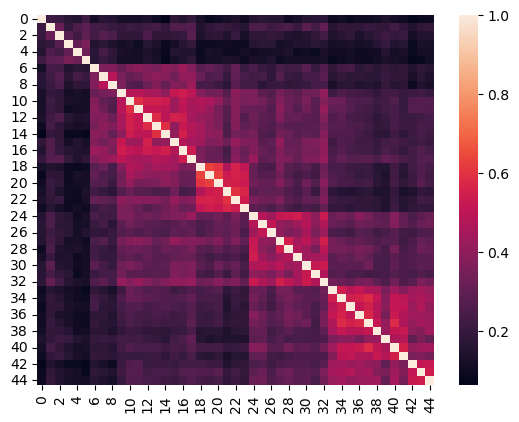

In [41]:
sns.heatmap(
    1 - pairwise_distances(phyto_abund_simplified.query("Basin == 'SouthTyr' and Det_level == 'Species'").pivot_table(index = ["Region", "id"], columns="Taxon", aggfunc="count", values="Num_cell_l", fill_value=0, observed=True).to_numpy(), 
                           metric = "jaccard")
)